In [1]:
import findspark
findspark.init()

import pyspark.sql.functions as F
import pyspark.sql.types as T

from etl import SparkETL
from age import Age
from stay import Stay
from dim import VisitorDim

Possible (but unlikely) **combinatorial explosion** for foreign_visitor_dim:
```
            'citizenship_id', 200 values
            'residence_id',   200 values
            'age_id',         5 values
            'gender_id',      3 values
            'visa_id',        3 values
            'address_id',     50 values
            'stay_id'         4 values
```

In [2]:
print('potentially num_rows ~= %e' % (200 * 200 * 5 * 3 * 3 * 50 * 4))

potentially num_rows ~= 3.600000e+08


In [3]:
etl = SparkETL()
spark = etl.get_spark()
dim_helper = VisitorDim()

22/05/13 19:24:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
immigration = etl.read_clean_table('immigration')

In [5]:
def visitor_dim_nk(df):
    return (
        df.select(dim_helper.get_nk())
        .drop_duplicates()
    )

In [6]:
def join_immigration_with_visitor_dim(df):
    
    visitor_dim = etl.read_dim_table('foreign_visitor_dim')
    
    return (
        df
        .join(
            visitor_dim, on=dim_helper.on_nk(df, visitor_dim), how='leftanti'
        )
    )

In [7]:
def fill_sk(df):
    return df.withColumn('visitor_id', F.expr(dim_helper.gen_sk_expr()))

In [8]:
def fill_country(df, country, left_on, alias):
    return (
        df
        .join(country, on=df[left_on] == country['country_id'], how='left')
        .withColumnRenamed('country', alias)
        .drop('country_id')
    )

In [9]:
@F.udf(T.StringType())
def fill_age_udf(age_id):
    return Age.descriptions[age_id] if age_id else age_id

In [10]:
def fill_age(df):
    return df.withColumn('age', fill_age_udf(F.col('age_id')))

In [11]:
def fill_gender(df):
    return df.withColumn(
        'gender',
        F.expr("""
            CASE gender_id
                WHEN 'F' THEN 'Female'
                WHEN 'M' THEN 'Male'
                ELSE gender_id
            END
        """)
    )

In [12]:
def fill_visa(df):
    return df.withColumn(
        'visa',
        F.expr("""
            CASE visa_id
                WHEN 1 THEN 'Business'
                WHEN 2 THEN 'Pleasure'
                WHEN 3 THEN 'Student'
                ELSE visa_id
            END
        """)
    )

In [13]:
def fill_state(df, state):
    return (
        df
        .join(
            state,
            on=df['address_id'] == state['state_id'],
            how='left'
        )
        .drop('state_id')
        .withColumnRenamed('name', 'address_state')
        .withColumnRenamed('type_id', 'address_type_id')
        .withColumnRenamed('type', 'address_type')
    )

In [14]:
def fill_climate(df, temperature):
    return (
        df
        .join(
            temperature,
            on=df['address_id'] == temperature['state_id'],
            how='left'
        )
        .drop('state_id')
        .withColumnRenamed('climate_id', 'address_climate_id')
        .withColumnRenamed('climate', 'address_climate')
    )

In [15]:
@F.udf(T.StringType())
def fill_stay_udf(stay_id):
    return Stay.descriptions[stay_id]

In [16]:
def fill_stay(df):
    return df.withColumn('stay', fill_stay_udf(F.col('stay_id')))

In [17]:
def project_schema(df):
    return df.select(
        'visitor_id',
        'citizenship_id',
        'residence_id',
        'age_id',
        'gender_id',
        'visa_id',
        'address_id',
        'stay_id',
        'citizenship',
        'residence',
        'age',
        'gender',
        'visa',
        'address_state',
        'address_type_id',
        'address_type',
        'address_climate_id',
        'address_climate',
        'stay'
    )

In [18]:
def missing_visitor(df, date):
    
    country = etl.read_clean_table('country')
    state = etl.read_clean_table('state')
    temperature = etl.read_clean_table('temperature')

    return (
        immigration
        .pipe(SparkETL.filter_one_month, date)
        .pipe(visitor_dim_nk)
        .pipe(join_immigration_with_visitor_dim)
        .pipe(fill_sk)
        .pipe(fill_country, country, 'citizenship_id', 'citizenship')
        .pipe(fill_country, country, 'residence_id', 'residence')
        .pipe(fill_age)
        .pipe(fill_gender)
        .pipe(fill_visa)
        .pipe(fill_state, state)
        .pipe(fill_climate, temperature)
        .pipe(fill_stay)
        .pipe(project_schema)
    )

In [19]:
etl.save_dim_table(
    immigration.pipe(missing_visitor, date),
    'foreign_visitor_dim'
)

NameError: name 'date' is not defined

In [25]:
from datetime import datetime

for month in range(1,13):
    date = f"2016-{month:02d}-01"
    print(date)
    etl.save_dim_table(
        immigration.pipe(missing_visitor, date),
        'foreign_visitor_dim'
    )

2016-01-01


2016-02-01


2016-03-01


2016-04-01


2016-05-01


2016-06-01
2016-07-01


2016-08-01


2016-09-01


2016-10-01


2016-11-01


2016-12-01


In [26]:
visitor_dim = etl.read_dim_table('foreign_visitor_dim')

In [27]:
visitor_dim.select('visitor_id').count() == visitor_dim.select('visitor_id').drop_duplicates().count()

True

In [28]:
visitor_dim.select('visitor_id').count()

1028336

In [29]:
visitor_dim.select('visitor_id').drop_duplicates().count()

1028336

TODO: address_type_id and address_climate_id should be int instead of float

In [25]:
visitor_dim.limit(10).toPandas()

,visitor_id,citizenship_id,residence_id,age_id,gender_id,visa_id,address_id,stay_id,citizenship,residence,age,gender,visa,address_state,address_type_id,address_type,address_climate_id,address_climate,stay
0,8589934592,101,101,1,M,2,CT,2,ALBANIA,ALBANIA,Gen Z (7-22),Male,Pleasure,Connecticut,0.0,State,2.0,temperate,8-30 days
1,8589934593,696,696,3,F,2,UNKNOWN,2,VENEZUELA,VENEZUELA,Gen X (40-54),Female,Pleasure,None,NaN,None,NaN,None,8-30 days
2,8589934594,104,104,3,M,2,HI,2,BELGIUM,BELGIUM,Gen X (40-54),Male,Pleasure,Hawaii,0.0,State,4.0,tropical,8-30 days
3,8589934595,101,101,5,M,2,MA,4,ALBANIA,ALBANIA,Senior (>75),Male,Pleasure,Massachusetts,0.0,State,1.0,continental,not departed
4,8589934596,696,696,1,M,2,CA,2,VENEZUELA,VENEZUELA,Gen Z (7-22),Male,Pleasure,California,0.0,State,3.0,warm,8-30 days
5,8589934597,104,104,4,F,2,UNKNOWN,0,BELGIUM,BELGIUM,Boomer (55-75),Female,Pleasure,None,NaN,None,NaN,None,1 day
6,8589934598,696,696,2,M,3,CO,3,VENEZUELA,VENEZUELA,Millennial (23-38),Male,Student,Colorado,0.0,State,1.0,continental,>30 days
7,8589934599,101,101,2,M,2,TN,2,ALBANIA,ALBANIA,Millennial (23-38),Male,Pleasure,Tennessee,0.0,State,3.0,warm,8-30 days
8,8589934600,101,101,4,M,2,UNKNOWN,4,ALBANIA,ALBANIA,Boomer (55-75),Male,Pleasure,None,NaN,None,NaN,None,not departed
9,8589934601,101,101,5,F,2,NV,4,ALBANIA,ALBANIA,Senior (>75),Female,Pleasure,Nevada,0.0,State,2.0,temperate,not departed


In [72]:
import pandas as pd
pd.set_option('display.max_rows', 2000)

In [98]:
col = 'stay'

<AxesSubplot:ylabel='stay'>

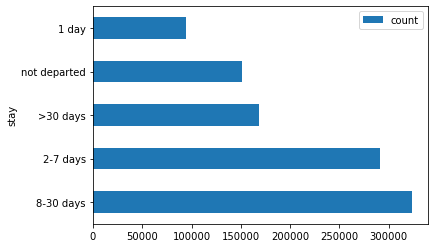

In [99]:
(
    visitor_dim
    .groupby(col)
    .count()
    .sort(F.desc('count'))
).toPandas().iloc[:20].plot(x=col, y='count', kind='barh')